In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://aifactory.space/competition/detail/2226

# Git

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023

브랜치
- master
- ksw_main

In [ ]:
!git branch ksw_main

In [ ]:
!git checkout master

Switched to branch 'master'
Your branch is up to date with 'origin/master'.


In [ ]:
!git remote update


Fetching origin
Already on 'ksw_main'


In [ ]:
!git checkout ksw_main

Switched to branch 'ksw_main'


In [ ]:
!git add --all

In [ ]:
!git branch

  ksw_main
* master


In [ ]:
!git config --global user.email "dhjkl123@naver.com"
!git config --global user.name "dhjkl123"
!git commit -m '20230406 ksw 16시 제출'

[master 23db6e0] 20230406 ksw 16시 제출
 5 files changed, 2 insertions(+), 1 deletion(-)
 create mode 100644 "\341\204\200\341\205\257\341\206\253\341\204\211\341\205\245\341\206\250\341\204\213\341\205\257\341\206\253/IsolationForest.pickle"
 create mode 100644 "\341\204\200\341\205\257\341\206\253\341\204\211\341\205\245\341\206\250\341\204\213\341\205\257\341\206\253/abod.pickle"
 create mode 100644 "\341\204\200\341\205\257\341\206\253\341\204\211\341\205\245\341\206\250\341\204\213\341\205\257\341\206\253/autoencoder.h5"
 create mode 100644 "\341\204\200\341\205\257\341\206\253\341\204\211\341\205\245\341\206\250\341\204\213\341\205\257\341\206\253/test.ipynb"
 rewrite "\341\204\200\341\205\257\341\206\253\341\204\211\341\205\245\341\206\250\341\204\213\341\205\257\341\206\253/train.ipynb" (95%)


In [ ]:
!git push

Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 351.31 KiB | 3.90 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 1 local object.
To https://github.com/dhjkl123/AI_SPARK_Challenge_2023.git
   68fbba2..23db6e0  master -> master


# Train

## Import

In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import *

from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.backend import clear_session

import pickle
import numpy as np
import matplotlib.pyplot as plt

## Data Load

In [ ]:
df_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/Data/train_data.csv')

In [ ]:
def tyep_to_hp(type_no):
  if type_no == 1:
    return 20
  elif type_no == 2:
    return 10
  elif type_no == 3:
    return 50
  else:
    return 30


df_data = df_data.drop(axis=1, columns=['out_pressure'])
df_data['type'] = df_data['type'].apply(tyep_to_hp)


In [ ]:
df_data

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,20.53,1680.0,58.67,2.93,30
1,2.97,59.28,38.40,3142.0,74.91,3.75,30
2,1.91,45.29,24.73,2023.0,62.48,3.12,30
3,2.37,51.33,30.63,2506.0,67.84,3.39,30
4,1.90,45.21,24.65,2017.0,62.41,3.12,30
...,...,...,...,...,...,...,...
2458,2.28,50.20,29.53,2416.0,66.84,3.34,30
2459,2.04,46.94,26.34,2155.0,63.94,3.20,30
2460,1.19,35.74,15.39,1259.0,53.99,2.70,30
2461,1.21,36.00,15.64,1280.0,54.22,2.71,30


In [ ]:
df_data = df_data[(df_data['motor_vibe'] < 5) & (df_data['air_inflow'] < 3.5) & (df_data['motor_current'] < 45) & (df_data['air_end_temp'] > 35) & (df_data['motor_temp'] > 53) ]

In [ ]:
df_data

,air_inflow,air_end_temp,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,20.53,1680.0,58.67,2.93,30
1,2.97,59.28,38.40,3142.0,74.91,3.75,30
2,1.91,45.29,24.73,2023.0,62.48,3.12,30
3,2.37,51.33,30.63,2506.0,67.84,3.39,30
4,1.90,45.21,24.65,2017.0,62.41,3.12,30
...,...,...,...,...,...,...,...
2458,2.28,50.20,29.53,2416.0,66.84,3.34,30
2459,2.04,46.94,26.34,2155.0,63.94,3.20,30
2460,1.19,35.74,15.39,1259.0,53.99,2.70,30
2461,1.21,36.00,15.64,1280.0,54.22,2.71,30


## AutoEncoder

In [ ]:
clear_session()

def model(n_inputs):
  #n_inputs = df_data.shape[1]

  # configure
  input_data = Input(shape=(n_inputs,))

  # layers
  encoded = Dense(n_inputs//2, activation='relu')(input_data)
  batnorm = BatchNormalization()(encoded)
  dropout = Dropout(0.2)(batnorm)
  encoded = Dense(n_inputs//4, activation='relu')(dropout)
  batnorm = BatchNormalization()(encoded)
  dropout = Dropout(0.2)(batnorm)

  n_bottneck = 200
  bottneck = Dense(n_bottneck, activation='relu')(dropout)

  decoded = Dense(n_inputs//4, activation='relu')(bottneck)
  batnorm = BatchNormalization()(decoded)
  dropout = Dropout(0.2)(batnorm)
  decoded = Dense(n_inputs//2, activation='relu')(dropout)
  batnorm = BatchNormalization()(decoded)
  dropout = Dropout(0.2)(batnorm)
  decoded = Dense(n_inputs, activation='relu')(dropout)

  # Models
  autoencoder = Model(input_data, decoded) # autoencoder

  encoder = Model(input_data, encoded) # encoder
  return autoencoder

In [ ]:
clear_session()

n_inputs = df_data.shape[1]

# configure
input_data = Input(shape=(n_inputs,))

# layers
encoded = Dense(n_inputs//2, activation='relu')(input_data)
batnorm = BatchNormalization()(encoded)
dropout = Dropout(0.2)(batnorm)
encoded = Dense(n_inputs//4, activation='relu')(dropout)
batnorm = BatchNormalization()(encoded)
dropout = Dropout(0.2)(batnorm)

n_bottneck = 200
bottneck = Dense(n_bottneck, activation='relu')(dropout)

decoded = Dense(n_inputs//4, activation='relu')(bottneck)
batnorm = BatchNormalization()(decoded)
dropout = Dropout(0.2)(batnorm)
decoded = Dense(n_inputs//2, activation='relu')(dropout)
batnorm = BatchNormalization()(decoded)
dropout = Dropout(0.2)(batnorm)
decoded = Dense(n_inputs, activation='relu')(dropout)

# Models
autoencoder = Model(input_data, decoded) # autoencoder

encoder = Model(input_data, encoded) # encoder

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
es = EarlyStopping(monitor = 'val_loss',patience=5,restore_best_weights=True, verbose=1)

In [ ]:
scaler = MinMaxScaler()
train_df = scaler.fit_transform(df_data)

In [ ]:
x_train, x_val, _, _ = train_test_split(train_df,train_df,random_state=2023,test_size=0.3)

autoencoder.fit(x_train, x_train, epochs = 100, callbacks = [es], validation_split = 0.3)

Epoch 1/100
34/34 [==============================] - 3s 13ms/step - loss: 0.3144 - val_loss: 0.3070
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2584 - val_loss: 0.2951
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2476 - val_loss: 0.2762
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 0.2251 - val_loss: 0.2506
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2047 - val_loss: 0.2253
Epoch 6/100
34/34 [==============================] - 0s 6ms/step - loss: 0.1836 - val_loss: 0.2060
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 0.1695 - val_loss: 0.1908
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 0.1583 - val_loss: 0.1789
Epoch 9/100
34/34 [==============================] - 0s 6ms/step - loss: 0.1487 - val_loss: 0.1703
Epoch 10/100
34/34 [==============================] - 0s 5ms/step - loss: 0.1445 - val_loss: 0.1635
Epoch 11

In [ ]:
reconstructions = autoencoder.predict(x_val)
train_loss = tf.keras.losses.mae(reconstructions, x_val)

21/21 [==============================] - 0s 2ms/step


In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.3233443026341315


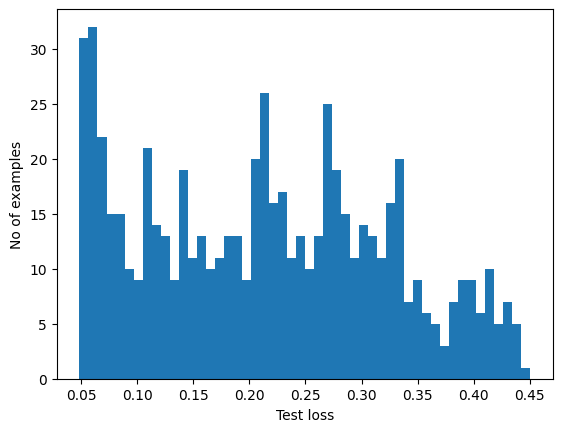

In [ ]:
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  pred = tf.math.less(loss, threshold)
  pred = np.where(pred,0,1)
  return pred

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))



In [ ]:
preds = predict(autoencoder, x_val, threshold)
print_stats(preds, np.array([0]*x_val.shape[0]))

Accuracy = 0.810477657935285


In [ ]:
autoencoder.fit(train_df, train_df, epochs = 100, callbacks = [es], validation_split = 0.3)

Epoch 1/100
48/48 [==============================] - 0s 7ms/step - loss: 0.0729 - val_loss: 0.0634
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0722 - val_loss: 0.0645
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0724 - val_loss: 0.0652
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0721 - val_loss: 0.0663
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0718 - val_loss: 0.0651
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0714 - val_loss: 0.0651
Epoch 6: early stopping


In [ ]:
autoencoder.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/autoencoder.h5')

## 모델 4개

In [ ]:
type_list = []
type_tmp_2 = []
type_tmp_1 = []
type_tmp_5 = []
type_tmp_e = []


for i,row in df_data.iterrows():
  #print(row)
  
  if row['type'] == 20:
    type_tmp_2.append(row)
  elif row['type'] == 10:
    type_tmp_1.append(row)
  elif row['type'] == 50:
    type_tmp_5.append(row)
  else:
    type_tmp_e.append(row)

type_list.append(type_tmp_2)
type_list.append(type_tmp_1)
type_list.append(type_tmp_5)
type_list.append(type_tmp_e)

In [ ]:
df_list = []

for ls in type_list:
  df = pd.DataFrame(ls).drop(axis=1,columns=['type'])
  df_list.append(df)
  print(df.shape)

(328, 6)
(315, 6)
(96, 6)
(1422, 6)


In [ ]:
models = []
scalers = []
clear_session()

for i in range(4):
  print('='*30)
  print(i)

  df = df_list[i]
  model_tmp = model(df.shape[1])
  model_tmp.compile(optimizer='adam', loss='mse')

  es = EarlyStopping(monitor = 'val_loss',patience=5,restore_best_weights=True, verbose=1)

  scaler = MinMaxScaler()
  scarer_df = scaler.fit_transform(df)
  scalers.append(scaler)

  model_tmp.fit(scarer_df, scarer_df, epochs = 100, callbacks = [es], validation_split = 0.3)

  models.append(model_tmp)


0
Epoch 1/100
8/8 [==============================] - 5s 47ms/step - loss: 0.2119 - val_loss: 0.2956
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1973 - val_loss: 0.2869
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.2121 - val_loss: 0.2792
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1791 - val_loss: 0.2734
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.1799 - val_loss: 0.2678
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1697 - val_loss: 0.2625
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1600 - val_loss: 0.2573
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1651 - val_loss: 0.2523
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 0.1555 - val_loss: 0.2483
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1587 - val_loss: 0.2437
Epoch 11/100
8/8 [==

In [ ]:
string_list = ['2','1','5','e']

for i,m in enumerate(models): 
  m.save_weights('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/m_' + string_list[i] + '.h5')
  
  with open('/content/drive/MyDrive/Colab Notebooks/AI_SPARK/AI_SPARK_Challenge_2023/권석원/s_' + string_list[i] + '.pickle', 'wb') as f:
    pickle.dump(scalers[i], f)


## KFold

In [ ]:
kf = KFold(random_state=2023,shuffle=True)

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(df_data)):
  print('='*10)
  print(i)
  print('='*10)
  x_train = df_data.loc[train_index]
  x_test = df_data.loc[test_index]

  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(x_train)
  x_test = scaler.transform(x_test)

  